# exp04: AirREGI 翌日入電予測（acc_get_cnt復元版）

**exp03との違い**: acc_get_cntを標準化から元の整数値に復元してから特徴量エンジニアリング

- ベースライン: exp03
- 特徴量: exp03と同じ
- モデル: exp03と同じ
- **変更点**: acc_get_cntの標準化を復元（整数化）

## 重要な原則（exp03から継承）
1. 未来のデータを使わない（ラグ特徴量は過去のデータのみ）
2. 移動平均も過去のデータのみを使用
3. 訓練データとテストデータは時系列で分割

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ==================================================================================
# 標準化復元関数（Tomさんの手順）
# ==================================================================================

def recover_integer_from_standardized_z(
    z: pd.Series,
    assume_min_original: int = 0,
    tol: float = 1e-12,
    round_result: bool = True,
):
    """
    Tomさんの手順のコード化：
    - z（標準化済み系列）から、元が非負整数という仮定でスケール（σ）を推定
    - さらに最小値=assume_min_original（通常0）という仮定でシフト（μ）を決める
    戻り値: (x復元系列, 推定パラメータdict)
    """
    z = z.astype(float)

    # 1) 標準化値の最小を基準に距離
    z_min = z.min()
    dist = (z - z_min).abs().sort_values()

    # 2) 距離の隣接差分から、最小の正の刻み(step)を探す
    diffs = dist.diff().dropna()
    step_candidates = diffs[diffs > tol]
    if step_candidates.empty:
        raise ValueError("step を推定できません（差分が全て 0 / tol 以下）")

    step = step_candidates.min()  # Tomさんはここを採用していた

    # step ≒ 1/σ なので σ 推定
    sigma = 1.0 / step

    # 3) 最小値=assume_min_original（通常0）仮定で μ 推定
    # z_min = (x_min - μ)/σ  =>  μ = x_min - z_min*σ
    mu = assume_min_original - z_min * sigma

    # 4) 逆変換
    x = z * sigma + mu

    if round_result:
        x_int = np.rint(x).astype(int)  # 浮動小数の誤差を丸めて整数化
        # （任意）丸め誤差チェックしたければ:
        # err = np.max(np.abs(x - x_int))
        return pd.Series(x_int, index=z.index, name=z.name), {
            "step(≈1/sigma)": step,
            "sigma": sigma,
            "mu": mu,
            "z_min": z_min,
        }

    return x, {
        "step(≈1/sigma)": step,
        "sigma": sigma,
        "mu": mu,
        "z_min": z_min,
    }

print("✅ 標準化復元関数を定義しました")

✅ 標準化復元関数を定義しました


In [3]:
# ==================================================================================
# Step 1: データの読み込みと前処理
# ==================================================================================

def load_and_preprocess_data():
    """
    各データセットを読み込み、日付型に変換
    """
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    # データ読み込み
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    # 日付カラムをdatetime型に変換
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nカレンダーデータ: {calender.shape}")
    print(f"CMデータ: {cm_data.shape}")
    print(f"Google Trendsデータ: {gt_service.shape}")
    print(f"アカウント取得データ: {acc_get.shape}")
    print(f"入電データ（目的変数）: {call_data.shape}")
    
    # 🚨 exp04: acc_get_cntを標準化から復元
    print("\n" + "=" * 80)
    print("🔧 exp04: acc_get_cntの標準化を復元")
    print("=" * 80)
    
    z_series = acc_get['acc_get_cnt']
    print(f"標準化済みデータ: min={z_series.min():.4f}, max={z_series.max():.4f}")
    
    x_recovered, params = recover_integer_from_standardized_z(
        z_series,
        assume_min_original=0,
        round_result=True
    )
    
    print(f"\n推定パラメータ:")
    for key, val in params.items():
        print(f"  {key}: {val}")
    
    print(f"\n復元後: min={x_recovered.min()}, max={x_recovered.max()}")
    print(f"データ型: {x_recovered.dtype}")
    
    # acc_get_cntを復元値で置き換え
    acc_get['acc_get_cnt'] = x_recovered
    
    print("✅ acc_get_cntを整数値に復元しました")
    
    return calender, cm_data, gt_service, acc_get, call_data

In [4]:
# ==================================================================================
# Step 2: データの統合
# ==================================================================================

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    """
    全てのデータセットを統合
    Google Trendsは週次データなので日次に展開
    """
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    # メインデータ（入電数）を基準にマージ
    df = call_data.copy()
    print(f"\nベースデータ: {df.shape}")
    
    # カレンダー情報をマージ
    df = df.merge(calender, on='cdr_date', how='left')
    print(f"カレンダー情報マージ後: {df.shape}")
    
    # CM情報をマージ
    df = df.merge(cm_data, on='cdr_date', how='left')
    print(f"CM情報マージ後: {df.shape}")
    
    # アカウント取得数をマージ（復元済み）
    df = df.merge(acc_get, on='cdr_date', how='left')
    print(f"アカウント取得数マージ後: {df.shape}")
    print(f"  acc_get_cnt: min={df['acc_get_cnt'].min()}, max={df['acc_get_cnt'].max()} (整数値)")
    
    # Google Trendsデータは週次なので日次に展開
    print("\nGoogle Trendsデータを週次→日次に展開...")
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({
                'cdr_date': date, 
                'search_cnt': row['search_cnt']
            })
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    print(f"Google Trendsマージ後: {df.shape}")
    
    # 欠損値の確認
    print("\n欠損値の数:")
    print(df.isnull().sum().sort_values(ascending=False).head(10))
    
    return df

In [5]:
# ==================================================================================
# Step 3: 基本的な時系列特徴量の作成
# ==================================================================================

def create_basic_time_features(df):
    """
    日付から派生する基本的な時系列特徴量を作成
    これらは未来の情報を使わないので安全
    """
    print("\n" + "=" * 80)
    print("Step 3: 基本的な時系列特徴量の作成")
    print("=" * 80)
    
    df = df.copy()
    
    # 年月日の特徴量
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    
    # 週の情報（既にwoy, womがあるが念のため）
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    
    # 経過日数（データの開始日からの日数）
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    
    # 月初・月末フラグ
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    
    print("\n作成した基本特徴量:")
    time_features = ['year', 'month', 'day_of_month', 'quarter', 'day_of_year', 
                     'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end']
    print(time_features)
    
    return df

In [6]:
# ==================================================================================
# Step 4: ラグ特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    """
    ラグ特徴量（過去のデータ）を作成
    """
    print("\n" + "=" * 80)
    print("Step 4: ラグ特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"作成するラグ: {lags}")
    
    for lag in lags:
        col_name = f'lag_{lag}'
        df[col_name] = df[target_col].shift(lag)
        print(f"  作成: {col_name} (shift={lag})")
    
    print(f"\n注意: 最初の{max(lags)}日間はラグ特徴量がNaNになります")
    
    return df

In [7]:
# ==================================================================================
# Step 5: 移動平均特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    """
    移動平均・移動標準偏差を作成
    """
    print("\n" + "=" * 80)
    print("Step 5: 移動平均特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"移動平均ウィンドウ: {windows}")
    
    for window in windows:
        # 移動平均（当日を含まない＝shift(1)してからrolling）
        ma_col = f'ma_{window}'
        df[ma_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        print(f"  作成: {ma_col} (過去{window}日間の平均)")
        
        # 移動標準偏差（変動の大きさを捉える）
        std_col = f'ma_std_{window}'
        df[std_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
        print(f"  作成: {std_col} (過去{window}日間の標準偏差)")
    
    print("\nなぜshift(1)が必要か:")
    print("  × 悪い例: rolling(3).mean() → 当日含む3日間の平均（リーケージ！）")
    print("  ○ 良い例: shift(1).rolling(3).mean() → 過去3日間の平均（安全）")
    
    return df

In [8]:
# ==================================================================================
# Step 6: その他の集約特徴量
# ==================================================================================

def create_aggregated_features(df):
    """
    その他の有用な集約特徴量を作成
    """
    print("\n" + "=" * 80)
    print("Step 6: その他の集約特徴量")
    print("=" * 80)
    
    df = df.copy()
    
    # CM効果の累積（過去7日間のCM実施回数）
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    print("  作成: cm_7d (過去7日間のCM実施回数)")
    
    # Google Trendsの移動平均（ノイズ除去）
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: gt_ma_7 (過去7日間のGoogle Trends平均)")
    
    # アカウント取得数の移動平均（復元された整数値を使用）
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: acc_ma_7 (過去7日間のアカウント取得平均)")
    print(f"    acc_ma_7の範囲: {df['acc_ma_7'].min():.2f} ~ {df['acc_ma_7'].max():.2f}")
    
    # 曜日ごとの過去平均（同じ曜日の過去データの平均）
    print("\n  作成中: dow_avg (同じ曜日の過去平均)...")
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

In [9]:
# ==================================================================================
# Step 7: 特徴量の選択とデータ分割（翌日予測に変更）
# ==================================================================================

def select_features_and_split(df, test_months=3):
    """
    特徴量を選択し、訓練データとテストデータに分割
    
    重要: 時系列データは時間順に分割する
    **exp04変更点**: 目的変数を call_num.shift(-1) に変更（翌日予測）
    """
    print("\n" + "=" * 80)
    print("Step 7: 特徴量選択とデータ分割")
    print("=" * 80)
    
    # 🚨 exp04変更点: 翌日の入電数を目的変数にする
    df = df.copy()
    df['target_next_day'] = df['call_num'].shift(-1)
    print("\n🎯 exp04: 目的変数を翌日の入電数に設定 (call_num.shift(-1))")
    
    # 最後の行はtargetがNaNになるので削除
    df = df.dropna(subset=['target_next_day']).reset_index(drop=True)
    print(f"翌日データがない最終行を削除: {len(df)}行")
    
    # 平日のみを使用（土日は入電数が0なので予測不要）
    df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)
    print(f"\n平日のみに絞り込み: {len(df)} → {len(df_model)}行")
    
    # 特徴量リスト（exp03と同じ）
    feature_cols = [
        # 基本的な時系列特徴量
        'dow', 'day_of_month', 'month', 'quarter', 'year', 
        'days_from_start', 'day_of_year', 'week_of_year',
        'is_month_start', 'is_month_end',
        
        # カレンダー特徴量
        'woy', 'wom', 'day_before_holiday_flag',
        
        # 外部データ（acc_get_cntは復元済みの整数値）
        'cm_flg', 'acc_get_cnt', 'search_cnt',
        
        # 集約特徴量
        'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
        
        # ラグ特徴量
        'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
        
        # 移動平均特徴量
        'ma_3', 'ma_7', 'ma_14', 'ma_30',
        'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30'
    ]
    
    print(f"\n使用する特徴量数: {len(feature_cols)}")
    print("\n特徴量のカテゴリ:")
    print(f"  - 基本時系列: 10個")
    print(f"  - カレンダー: 3個")
    print(f"  - 外部データ: 3個 (acc_get_cnt復元済み)")
    print(f"  - 集約特徴量: 4個")
    print(f"  - ラグ特徴量: 7個")
    print(f"  - 移動平均: 8個")
    
    # acc_get_cntの統計
    print(f"\nacc_get_cnt統計 (復元後の整数値):")
    print(f"  min: {df_model['acc_get_cnt'].min()}")
    print(f"  max: {df_model['acc_get_cnt'].max()}")
    print(f"  mean: {df_model['acc_get_cnt'].mean():.2f}")
    print(f"  median: {df_model['acc_get_cnt'].median():.0f}")
    
    # 時系列分割（最後の3ヶ月をテストデータ）
    split_date = df_model['cdr_date'].max() - pd.Timedelta(days=30*test_months)
    
    train_df = df_model[df_model['cdr_date'] < split_date].copy()
    test_df = df_model[df_model['cdr_date'] >= split_date].copy()
    
    print(f"\n時系列分割:")
    print(f"  訓練データ期間: {train_df['cdr_date'].min()} ~ {train_df['cdr_date'].max()}")
    print(f"  テストデータ期間: {test_df['cdr_date'].min()} ~ {test_df['cdr_date'].max()}")
    print(f"  訓練データ数: {len(train_df)}行")
    print(f"  テストデータ数: {len(test_df)}行")
    
    # 欠損値がある行を削除（ラグ特徴量の初期値等）
    train_clean = train_df.dropna(subset=feature_cols + ['target_next_day'])
    test_clean = test_df.dropna(subset=feature_cols + ['target_next_day'])
    
    print(f"\n欠損値除去後:")
    print(f"  訓練データ数: {len(train_clean)}行")
    print(f"  テストデータ数: {len(test_clean)}行")
    
    # X（特徴量）とy（目的変数）に分割
    X_train = train_clean[feature_cols]
    y_train = train_clean['target_next_day']
    X_test = test_clean[feature_cols]
    y_test = test_clean['target_next_day']
    
    # メタ情報も保存（日付など）
    train_meta = train_clean[['cdr_date', 'call_num', 'target_next_day']]
    test_meta = test_clean[['cdr_date', 'call_num', 'target_next_day']]
    
    return X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols

In [10]:
# ==================================================================================
# Step 8: 特徴量の重要度確認用関数
# ==================================================================================

def analyze_features(X_train, y_train, feature_cols):
    """
    特徴量の基本統計と相関を確認
    """
    print("\n" + "=" * 80)
    print("Step 8: 特徴量の分析")
    print("=" * 80)
    
    # 基本統計量
    print("\n特徴量の基本統計:")
    print(X_train.describe().T[['mean', 'std', 'min', 'max']].head(10))
    
    # acc_get_cntの統計（復元後）
    if 'acc_get_cnt' in X_train.columns:
        print(f"\nacc_get_cnt (復元後):")
        print(f"  min:  {X_train['acc_get_cnt'].min()}")
        print(f"  max:  {X_train['acc_get_cnt'].max()}")
        print(f"  mean: {X_train['acc_get_cnt'].mean():.2f}")
        print(f"  std:  {X_train['acc_get_cnt'].std():.2f}")
    
    # 目的変数との相関
    print("\n目的変数（翌日入電数）との相関（上位10）:")
    correlations = pd.DataFrame({
        'feature': feature_cols,
        'correlation': [X_train[col].corr(y_train) for col in feature_cols]
    }).sort_values('correlation', ascending=False, key=abs)
    
    print(correlations.head(10))
    
    return correlations

In [11]:
# ==================================================================================
# メイン実行関数
# ==================================================================================

def main():
    """
    全ての処理を実行
    """
    print("\n")
    print("*" * 80)
    print("exp04: AirREGI ヘルプデスク 翌日入電予測 (acc_get_cnt復元版)")
    print("*" * 80)
    
    # Step 1: データ読み込み（acc_get_cnt復元を含む）
    calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
    
    # Step 2: データ統合
    df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
    
    # Step 3: 基本時系列特徴量
    df = create_basic_time_features(df)
    
    # Step 4: ラグ特徴量
    df = create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30])
    
    # Step 5: 移動平均特徴量
    df = create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30])
    
    # Step 6: その他集約特徴量
    df = create_aggregated_features(df)
    
    # Step 7: 特徴量選択とデータ分割（翌日予測版）
    X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols = \
        select_features_and_split(df, test_months=3)
    
    # Step 8: 特徴量分析
    correlations = analyze_features(X_train, y_train, feature_cols)
    
    # データ保存
    print("\n" + "=" * 80)
    print("データの保存")
    print("=" * 80)
    
    # output ディレクトリが存在しない場合は作成
    import os
    output_dir = '../output/exp04'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"  {output_dir} ディレクトリを作成しました")
    
    train_data = pd.concat([train_meta.reset_index(drop=True), 
                           X_train.reset_index(drop=True)], axis=1)
    test_data = pd.concat([test_meta.reset_index(drop=True), 
                          X_test.reset_index(drop=True)], axis=1)
    
    train_data.to_csv(f'{output_dir}/train_features.csv', index=False)
    test_data.to_csv(f'{output_dir}/test_features.csv', index=False)
    correlations.to_csv(f'{output_dir}/feature_correlations.csv', index=False)
    
    print("\n保存完了:")
    print(f"  - {output_dir}/train_features.csv")
    print(f"  - {output_dir}/test_features.csv")
    print(f"  - {output_dir}/feature_correlations.csv")
    
    print("\n" + "=" * 80)
    print("特徴量エンジニアリング完了！")
    print("=" * 80)
    print(f"\n訓練データ: {X_train.shape}")
    print(f"テストデータ: {X_test.shape}")
    print(f"特徴量数: {len(feature_cols)}")
    print(f"\n🎯 目的変数: 翌日の入電数 (call_num.shift(-1))")
    print(f"🔧 acc_get_cnt: 標準化から復元済み（整数値）")
    
    return df, X_train, X_test, y_train, y_test, feature_cols

In [12]:
# ==================================================================================
# 実行
# ==================================================================================

if __name__ == "__main__":
    df, X_train, X_test, y_train, y_test, feature_cols = main()



********************************************************************************
exp04: AirREGI ヘルプデスク 翌日入電予測 (acc_get_cnt復元版)
********************************************************************************
Step 1: データの読み込み

カレンダーデータ: (670, 10)
CMデータ: (762, 2)
Google Trendsデータ: (109, 2)
アカウント取得データ: (701, 2)
入電データ（目的変数）: (670, 2)

🔧 exp04: acc_get_cntの標準化を復元
標準化済みデータ: min=-1.5087, max=7.1480

推定パラメータ:
  step(≈1/sigma): 0.012384470302130524
  sigma: 80.7462875362516
  mu: 121.82310984308629
  z_min: -1.5087146859648868

復元後: min=0, max=699
データ型: int64
✅ acc_get_cntを整数値に復元しました

Step 2: データの統合

ベースデータ: (670, 2)
カレンダー情報マージ後: (670, 11)
CM情報マージ後: (670, 12)
アカウント取得数マージ後: (670, 13)
  acc_get_cnt: min=0, max=699 (整数値)

Google Trendsデータを週次→日次に展開...
Google Trendsマージ後: (670, 14)

欠損値の数:
holiday_name               632
cdr_date                     0
call_num                     0
dow                          0
dow_name                     0
woy                          0
wom                       

---

# モデル学習セクション（exp03と同じ）

In [13]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Example features:", feature_cols[:10])

Train: (391, 35) Test: (65, 35)
Example features: ['dow', 'day_of_month', 'month', 'quarter', 'year', 'days_from_start', 'day_of_year', 'week_of_year', 'is_month_start', 'is_month_end']


In [14]:
# =========================
# 1) Metrics helper
# =========================
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

results = []

def add_result(name, y_pred):
    m = evaluate(y_test, y_pred)
    results.append({"Model": name, **m})

In [15]:
# =========================
# 2) Baselines
# =========================
# test_features.csvから call_num を再読み込み
test_data_for_baseline = pd.read_csv("../output/exp04/test_features.csv")
baseline_current_day = test_data_for_baseline['call_num'].values

# (A) 当日踏襲: y_hat(t+1) = call_num(t)
add_result("Baseline: current_day (今日=明日)", baseline_current_day)

# (B) 先週同曜日踏襲
if "lag_7" in X_test.columns:
    add_result("Baseline: lag_7 (先週同曜日)", X_test["lag_7"].values)

# (C) 過去7日平均
if "ma_7" in X_test.columns:
    add_result("Baseline: ma_7 (過去7日平均)", X_test["ma_7"].values)

# (D) 混合
if "lag_7" in X_test.columns:
    yhat = 0.7 * baseline_current_day + 0.3 * X_test["lag_7"].values
    add_result("Baseline: 0.7*current + 0.3*lag_7", yhat)

print("✅ Baselines calculated")

✅ Baselines calculated


In [16]:
# =========================
# 3) Models（まずはsklearnで堅く）
# =========================
models = {}

models["Ridge"] = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])

models["RandomForest"] = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

models["ExtraTrees"] = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", ExtraTreesRegressor(
        n_estimators=800,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

models["GradientBoosting"] = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingRegressor(random_state=42))
])

models["HistGradientBoosting"] = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        max_depth=None,
        learning_rate=0.05,
        max_iter=2000,
        random_state=42
    ))
])

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    add_result(name, pred)

Training Ridge...
Training RandomForest...
Training ExtraTrees...
Training GradientBoosting...
Training HistGradientBoosting...


In [17]:
# =========================
# 4) 時系列validation分割（GBDT用）
# =========================
def time_valid_split_from_df(df, valid_days=60):
    """時系列validationデータを作成"""
    TARGET = "target_next_day"
    DROP_COLS = ["cdr_date", "call_num", TARGET]
    
    cutoff = df['cdr_date'].max() - pd.Timedelta(days=valid_days)
    
    tr_df = df[df['cdr_date'] < cutoff].copy()
    va_df = df[df['cdr_date'] >= cutoff].copy()
    
    X_tr = tr_df.drop(columns=DROP_COLS)
    y_tr = tr_df[TARGET].astype(float)
    X_va = va_df.drop(columns=DROP_COLS)
    y_va = va_df[TARGET].astype(float)
    
    return X_tr, y_tr, X_va, y_va

# trainデータを読み込んで分割
train_full = pd.read_csv("../output/exp04/train_features.csv", parse_dates=["cdr_date"])
X_tr, y_tr, X_va, y_va = time_valid_split_from_df(train_full, valid_days=60)
print(f"Training set: {X_tr.shape}, Validation set: {X_va.shape}")

Training set: (348, 35), Validation set: (43, 35)


In [18]:
# XGBoost
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(
        n_estimators=5000,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    print("Training XGBoost...")
    xgb.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
    pred = xgb.predict(X_test)
    add_result("XGBoost", pred)
    print("✅ XGBoost trained")
except Exception as e:
    print("[skip] XGBoost:", e)

Training XGBoost...
✅ XGBoost trained


In [19]:
# LightGBM
try:
    import lightgbm as lgb
    lgbm = lgb.LGBMRegressor(
        n_estimators=20000,
        learning_rate=0.02,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    print("Training LightGBM...")
    lgbm.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )
    pred = lgbm.predict(X_test)
    add_result("LightGBM", pred)
    print("✅ LightGBM trained")
except Exception as e:
    print("[skip] LightGBM:", e)

Training LightGBM...
✅ LightGBM trained


In [20]:
# CatBoost
try:
    from catboost import CatBoostRegressor
    cat = CatBoostRegressor(
        iterations=20000,
        learning_rate=0.03,
        depth=8,
        loss_function="MAE",
        random_seed=42,
        verbose=False
    )
    print("Training CatBoost...")
    cat.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True)
    pred = cat.predict(X_test)
    add_result("CatBoost", pred)
    print("✅ CatBoost trained")
except Exception as e:
    print("[skip] CatBoost:", e)

Training CatBoost...
✅ CatBoost trained


In [21]:
# =========================
# 5) Results
# =========================
res_df = pd.DataFrame(results).sort_values("MAE").reset_index(drop=True)
print("\n" + "="*80)
print("=== Results (sorted by MAE) ===")
print("="*80)
print(res_df)

# 保存
import os
output_dir = '../output/exp04'
os.makedirs(output_dir, exist_ok=True)
res_df.to_csv(f"{output_dir}/model_results.csv", index=False)
print(f"\n✅ Saved: {output_dir}/model_results.csv")


=== Results (sorted by MAE) ===
                                Model        MAE       RMSE        R2
0                          ExtraTrees  28.140587  38.941014  0.622898
1                            CatBoost  31.593947  39.773787  0.606597
2                               Ridge  39.526543  50.506921  0.365625
3                HistGradientBoosting  39.681473  58.495239  0.149087
4                    GradientBoosting  41.908422  62.281668  0.035361
5                        RandomForest  42.537297  58.970493  0.135204
6                             XGBoost  47.608386  59.560069  0.117825
7                            LightGBM  48.213174  55.923326  0.222268
8   Baseline: 0.7*current + 0.3*lag_7  48.972308  68.757881 -0.175680
9       Baseline: current_day (今日=明日)  50.415385  74.360763 -0.375092
10            Baseline: ma_7 (過去7日平均)  57.749451  67.932329 -0.147618
11            Baseline: lag_7 (先週同曜日)  67.861538  86.400053 -0.856403

✅ Saved: ../output/exp04/model_results.csv



Best Model: CatBoost
Test MAE : 31.594
Test RMSE: 39.774
Test R2  : 0.607


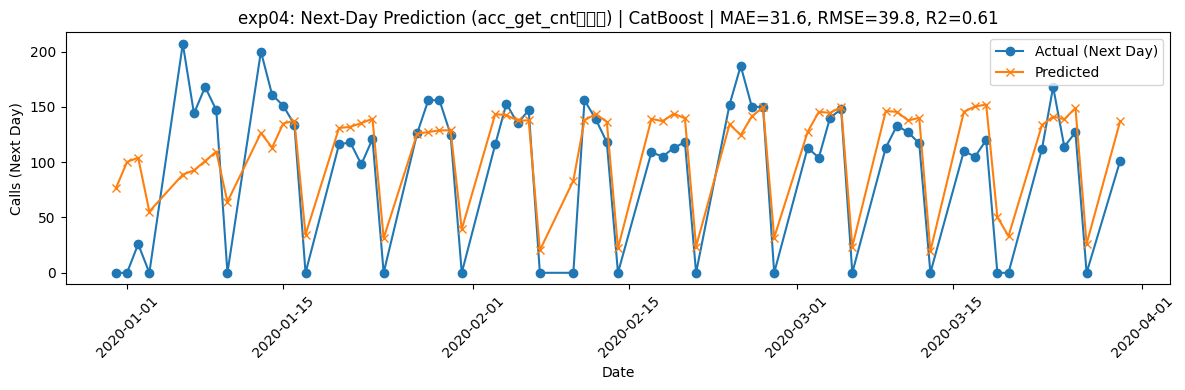

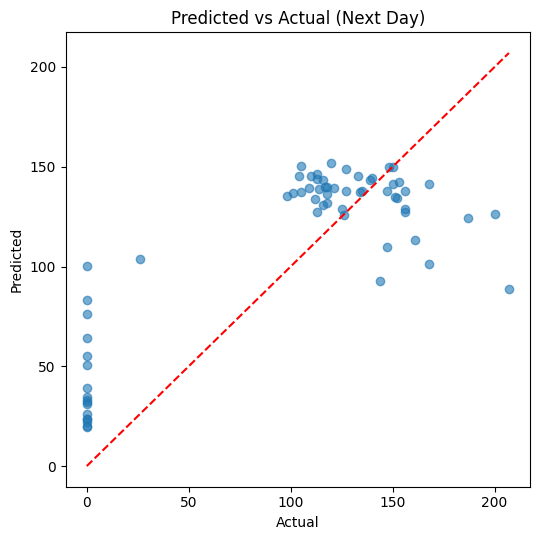


✅ Plots saved to ../output/exp04/
exp04 complete!


In [22]:
# =========================
# 6) Visualization
# =========================
import matplotlib.pyplot as plt

# ベストモデルの予測を取得
try:
    best_pred = cat.predict(X_test)
    model_name = "CatBoost"
except:
    try:
        best_pred = lgbm.predict(X_test)
        model_name = "LightGBM"
    except:
        try:
            best_pred = xgb.predict(X_test)
            model_name = "XGBoost"
        except:
            best_pred = models["Ridge"].predict(X_test)
            model_name = "Ridge"

mae = mean_absolute_error(y_test, best_pred)
rmse = mean_squared_error(y_test, best_pred, squared=False)
r2 = r2_score(y_test, best_pred)

print(f"\nBest Model: {model_name}")
print(f"Test MAE : {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2  : {r2:.3f}")

# CSV から再読み込み
test_data_for_plot = pd.read_csv("../output/exp04/test_features.csv", parse_dates=["cdr_date"])
plot_df = pd.DataFrame({
    "date": test_data_for_plot['cdr_date'].values,
    "actual": y_test.values,
    "pred": np.asarray(best_pred, dtype=float)
}).sort_values("date")

# 図1：時系列
plt.figure(figsize=(12, 4))
plt.plot(plot_df["date"], plot_df["actual"], label="Actual (Next Day)", marker='o')
plt.plot(plot_df["date"], plot_df["pred"], label="Predicted", marker='x')
plt.title(f"exp04: Next-Day Prediction (acc_get_cnt復元版) | {model_name} | MAE={mae:.1f}, RMSE={rmse:.1f}, R2={r2:.2f}")
plt.xlabel("Date")
plt.ylabel("Calls (Next Day)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_dir}/prediction_timeseries.png", dpi=150)
plt.show()

# 図2：散布図
plt.figure(figsize=(5.5, 5.5))
plt.scatter(plot_df["actual"], plot_df["pred"], alpha=0.6)
mn = min(plot_df["actual"].min(), plot_df["pred"].min())
mx = max(plot_df["actual"].max(), plot_df["pred"].max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.title("Predicted vs Actual (Next Day)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig(f"{output_dir}/prediction_scatter.png", dpi=150)
plt.show()

print(f"\n✅ Plots saved to {output_dir}/")
print("="*80)
print("exp04 complete!")
print("="*80)

## ✅ exp04完了

### exp03との違い
- **acc_get_cnt**: 標準化値 → **整数値に復元**
- **acc_ma_7**: 標準化値の移動平均 → **整数値の移動平均**
- その他の特徴量・モデル: exp03と同じ

### 期待される効果
- acc_get_cntが元のスケールになることで、モデルが解釈しやすくなる
- 整数値として扱うことで、特徴量エンジニアリングが自然になる
- CatBoostなどのツリーベースモデルでは、スケールの影響は少ないが、解釈性が向上

### 出力ファイル
- `output/exp04/train_features.csv` - 訓練データ（acc_get_cnt復元済み）
- `output/exp04/test_features.csv` - テストデータ（acc_get_cnt復元済み）
- `output/exp04/feature_correlations.csv` - 特徴量相関
- `output/exp04/model_results.csv` - 全モデルの評価結果
- `output/exp04/prediction_timeseries.png` - 時系列予測プロット
- `output/exp04/prediction_scatter.png` - 散布図

exp03 - CatBoost Feature Importance

Total features: 35

Top 20 features:
                feature  importance
day_before_holiday_flag   28.628536
                    dow   10.456739
            acc_get_cnt    5.160970
                  lag_5    4.463161
                  cm_7d    3.082701
           day_of_month    3.044511
        days_from_start    2.990110
                  lag_1    2.865605
               ma_std_7    2.714920
               ma_std_3    2.489843
                   ma_7    2.394009
             search_cnt    2.385813
               acc_ma_7    2.370229
              ma_std_30    2.218760
                  lag_7    2.180058
                 lag_14    2.001307
                quarter    1.949727
                    wom    1.782072
                   ma_3    1.687423
                gt_ma_7    1.542862

✅ Saved to ../output/exp03/feature_importance.csv


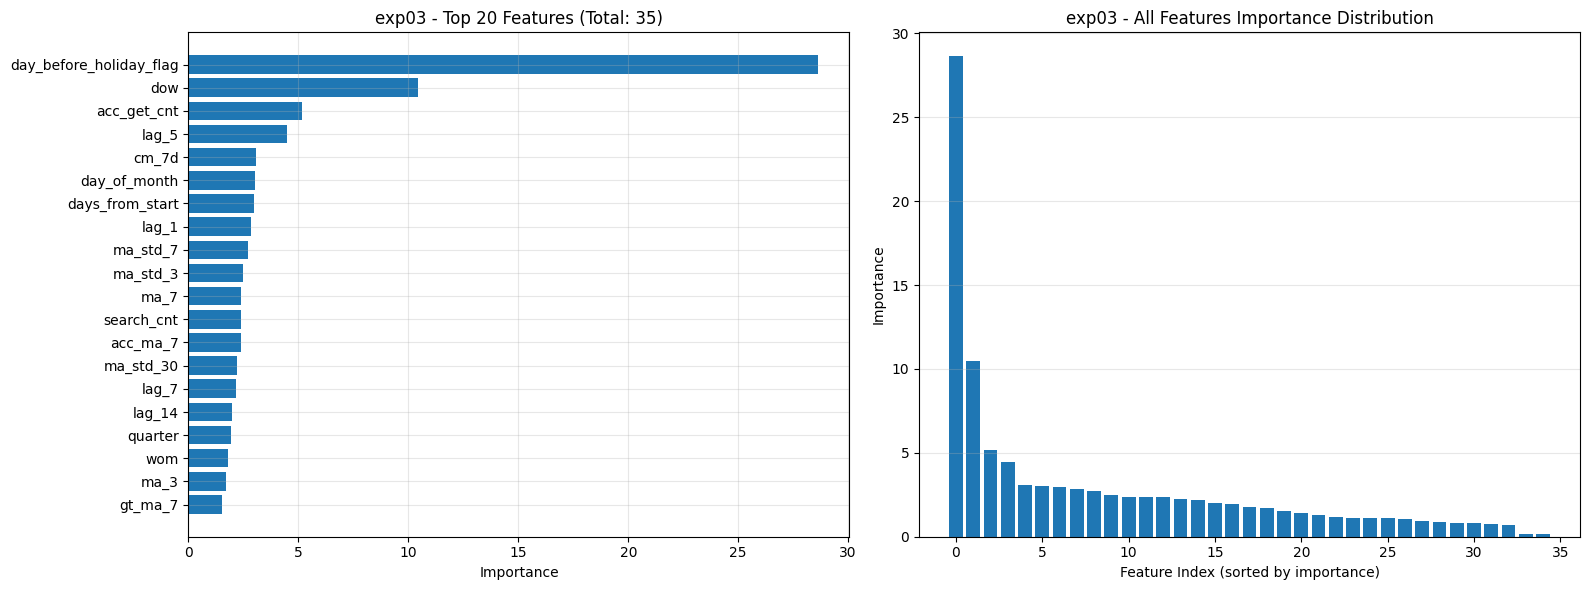


Feature Importance by Category
  Category  Total Importance
     Other         28.628536
      Time         25.230362
       Lag         14.384712
Moving Std          8.502882
  External          8.298205
Aggregated          8.288291
Moving Avg          6.667012


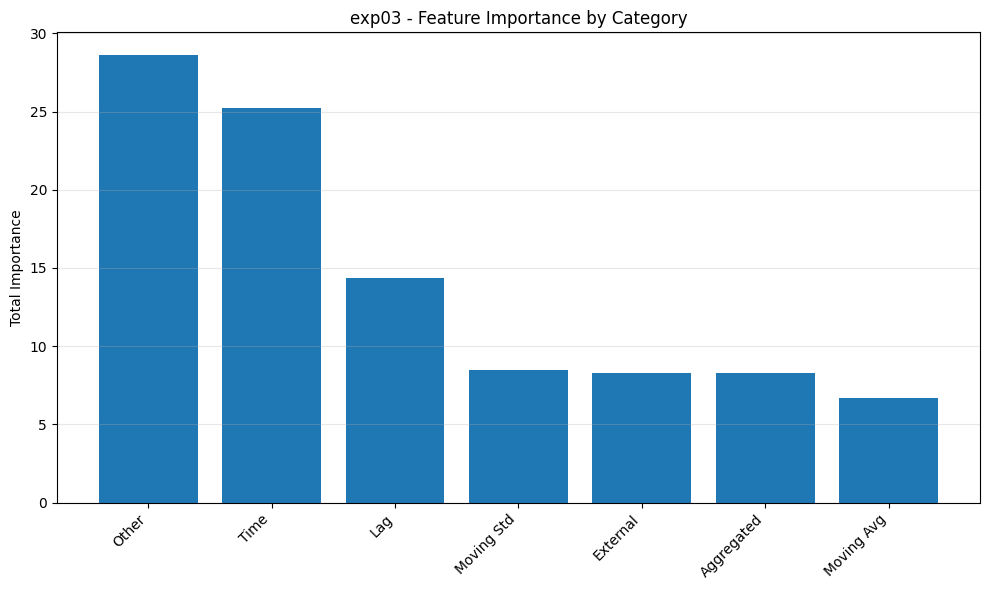

In [23]:
# exp03の特徴量重要度を取得・可視化
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CatBoostモデルから特徴量重要度を取得
# （既にモデル学習セクションを実行済みの前提）

print("="*60)
print("exp03 - CatBoost Feature Importance")
print("="*60)

# CatBoostモデルが学習済みであることを確認
try:
    # 特徴量重要度を取得
    feature_importance = cat.feature_importances_
    feature_names = X_test.columns.tolist()
    
    # DataFrameに整形
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    
    print(f"\nTotal features: {len(importance_df)}")
    print(f"\nTop 20 features:")
    print(importance_df.head(20).to_string(index=False))
    
    # 保存
    import os
    output_dir = '../output/exp03'
    os.makedirs(output_dir, exist_ok=True)
    importance_df.to_csv(f'{output_dir}/feature_importance.csv', index=False)
    print(f"\n✅ Saved to {output_dir}/feature_importance.csv")
    
    # 可視化1: Top 20
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 横棒グラフ
    ax = axes[0]
    top20 = importance_df.head(20).sort_values('importance')
    ax.barh(range(len(top20)), top20['importance'])
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['feature'])
    ax.set_xlabel('Importance')
    ax.set_title(f'exp03 - Top 20 Features (Total: {len(importance_df)})')
    ax.grid(True, alpha=0.3)
    
    # 棒グラフ（全特徴量）
    ax = axes[1]
    ax.bar(range(len(importance_df)), importance_df['importance'])
    ax.set_xlabel('Feature Index (sorted by importance)')
    ax.set_ylabel('Importance')
    ax.set_title('exp03 - All Features Importance Distribution')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/feature_importance_plot.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 可視化2: カテゴリ別の重要度
    print("\n" + "="*60)
    print("Feature Importance by Category")
    print("="*60)
    
    # カテゴリ分類
    categories = {
        'Lag': [f'lag_{i}' for i in [1,2,3,5,7,14,30]],
        'Moving Avg': ['ma_3', 'ma_7', 'ma_14', 'ma_30'],
        'Moving Std': ['ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30'],
        'Time': ['dow', 'day_of_month', 'month', 'quarter', 'year', 
                 'days_from_start', 'day_of_year', 'week_of_year',
                 'is_month_start', 'is_month_end', 'woy', 'wom'],
        'External': ['cm_flg', 'acc_get_cnt', 'search_cnt'],
        'Aggregated': ['cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg'],
        'Other': ['day_before_holiday_flag']
    }
    
    category_importance = {}
    for cat_name, features in categories.items():
        cat_imp = importance_df[importance_df['feature'].isin(features)]['importance'].sum()
        category_importance[cat_name] = cat_imp
    
    cat_df = pd.DataFrame({
        'Category': category_importance.keys(),
        'Total Importance': category_importance.values()
    }).sort_values('Total Importance', ascending=False)
    
    print(cat_df.to_string(index=False))
    
    # カテゴリ別の可視化
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(cat_df['Category'], cat_df['Total Importance'])
    ax.set_ylabel('Total Importance')
    ax.set_title('exp03 - Feature Importance by Category')
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/feature_importance_by_category.png', dpi=150, bbox_inches='tight')
    plt.show()
    
except NameError:
    print("⚠️ CatBoostモデル（cat）がまだ学習されていません")
    print("モデル学習セクションを先に実行してください")
except Exception as e:
    print(f"エラー: {e}")
